In [1]:
import nltk
import json
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter

import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import jaccard_similarity_score
from scipy import spatial
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
%matplotlib inline

import pickle
import string
from tqdm import tqdm, tqdm_notebook
import time


# Temp

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Functions

In [2]:
def createCorpus(json_data, stopwords):
    j = json_data
    corpus = []
    
    for data in tqdm_notebook(j['data']):
        for paragraph in data["paragraphs"]:
            context = paragraph["context"]
            corpus.append(context)
            for q in paragraph["qas"]:
                question = q["question"]
                corpus.append(question)
    return corpus

In [3]:
def getPOS(corpus, progress = True):
    pos_tag = []
    c = tqdm_notebook(corpus) if progress else corpus
    for sentence in c:
        text = nltk.word_tokenize(sentence)
        pos_tag = nltk.pos_tag(text)
    return pos_tag

In [4]:
def makePOSDict(corpus):
    pos = getPOS(corpus)
    pos_dict = {}
    for (word, tag) in tqdm_notebook(pos):
        wtag = tag[0].lower()
        wtag = wtag if wtag in ["a","r","n","v"] else None
        pos_dict[word] = wtag
        
    return pos_dict

makePOSDict(["Something is weird"])

{'Something': 'v', 'is': 'v', 'weird': None}

In [5]:
def ourLemmatize(dictonary, corpus):
    lemma = WordNetLemmatizer()
    corp = []
    for sentence in tqdm_notebook(corpus):
        s = nltk.word_tokenize(sentence)
        sent = []
        for word in s:
            if dictonary[word] != None:
                nw = lemma.lemmatize(word, dictonary[word])
                sent.append(nw)
            else:
                sent.append(word)
#         corp.append(" ".join(sent))
        corp.append(sent)
    return corp

In [6]:
# Make and load pickles
def makePickle(filename, data_file):
    pickle_out = open("pickles/" + filename + ".pickle","wb")
    pickle.dump(data_file, pickle_out)
    pickle_out.close()
    
def loadPickle(filename):
    pickle_in = open("pickles/" + filename + ".pickle","rb")
    return pickle.load(pickle_in)

In [7]:
def makeFeatures(features, pred = None):
    # dict to array
    y = []
    xs = []
    for k,v in features[0].items():
        x = [feature[k] for feature in features]
        
        xs.append(x)
        if pred != None:
            y.append(pred[k])
        else:
            y.append(k)
        
    Y = np.array(y)
    X = np.array(xs)
    
    return X,Y

In [8]:
def oneHotEncode(columnId, feature_data):
    # Select categorical data
    df = pd.DataFrame(data=feature_data)
    newdf = df.iloc[:,columnId:columnId+1]
    
    le = preprocessing.LabelEncoder()
    enc = preprocessing.OneHotEncoder()
    
    X_1 = df.drop([columnId],1)

    X_2 = newdf.apply(le.fit_transform)
    enc.fit(X_2)
    onehotlabels = enc.transform(X_2).toarray()
    X_2 =  pd.DataFrame(data=onehotlabels)
    
    feature_data = pd.concat([X_1, X_2], axis=1, sort=False)
    return feature_data.values

In [9]:
def saveToFile(preds, keys, filename):
    predictions = {}
    for i in range(len(keys)):
        key = keys[i]
        predictions[key] = preds[i]
    
    with open(filename + '.csv', 'w') as f:
        f.write("Id,Category\n")
        for k,v in predictions.items():
            f.write("%s,%s\n"%(k,v))

        f.close()

## Load data

In [13]:
with open('training.json') as f:
    json_data = json.load(f)
with open('development.json') as f:
    json_data_validate = json.load(f)

In [65]:
try:
    corpus = loadPickle('corpus')
except:
    stop_words = set(stopwords.words('english'))
    stop_words.union(set(string.punctuation))
    corpus = createCorpus(json_data, stop_words)
    makePickle('corpus', corpus)

corpus[1]

'What was the first album Beyoncé released as a solo artist?'

In [66]:
try:
    corpus_val = loadPickle('corpus_val')
except:
    stop_words = set(stopwords.words('english'))
    stop_words.union(set(string.punctuation))
    corpus_val = createCorpus(json_data_validate, stop_words)
    makePickle('corpus_val', corpus_val)

corpus_val[1]

'When did Beyoncé release Dangerously in Love?'

### POS Dict and Lemmatized corpus

In [35]:
try:
    pos_dict = loadPickle('pos_dic')
except:
    pos_dict = makePOSDict(corpus)
    makePickle('pos_dic', pos_dict)
    
next(iter(pos_dict.keys())), next(iter(pos_dict.values()))

('Beyoncé', 'n')

In [38]:
try:
    corpus_lemmatize = loadPickle('corpus_lemmatize')
except:
    corpus_lemmatize = ourLemmatize(pos_dict, corpus)
    makePickle('corpus_lemmatize', corpus_lemmatize)

corpus_lemmatize[1][:4]

['What', 'be', 'the', 'first']

In [69]:
try:
    pos_dic_val = loadPickle('pos_dic_val')
except:
    pos_dic_val = makePOSDict(corpus_val)
    makePickle('pos_dic_val', pos_dic_val)
    
next(iter(pos_dic_val.keys())), next(iter(pos_dic_val.values()))

('Beyoncé', 'n')

In [70]:
try:
    corpus_lemmatize_val = loadPickle('corpus_lemmatize_val')
except:
    corpus_lemmatize_val = ourLemmatize(pos_dic_val, corpus_val)
    makePickle('corpus_lemmatize_val', corpus_lemmatize_val)
    
corpus_lemmatize_val[1][:4]

['When', 'do', 'Beyoncé', 'release']

## Predictions

In [14]:
def getPredictions(json_data):
    pred = {}
    for obj in tqdm_notebook(json_data["data"]):
        for para in obj["paragraphs"]:
            for q in para["qas"]:
                question_id = q["id"]
                pred[question_id] = 0 if q["is_impossible"] else 1
                
    return pred

In [15]:
pred =  getPredictions(json_data)
pred_validate = getPredictions(json_data_validate)

## Jaccard Sentence

In [22]:
# Jaccard Similarity function
def DistJaccard(str1, str2):
    str1 = set(str1)
    str2 = set(str2)
    jd = nltk.jaccard_distance(str1, str2)
#     manual = float(len(str1 & str2)) / len(str1 | str2)
    return jd

DistJaccard("something stuped okay lol","Okay cool lol")

0.6842105263157895

In [23]:
def getJaccard(json_data, corpus):
    jac_similarity = {}
    counter = 0
    for obj in tqdm_notebook(json_data["data"]):
        for para in obj["paragraphs"]:
            context = corpus[counter]

            counter += 1
            for q in para["qas"]:
                question_id = q["id"]
                question = corpus[counter]
                
                sim = np.array([DistJaccard(sent,question) for sent in context.split(".")])
                jac_similarity[question_id] = np.mean(sim)
                
                counter += 1
                
    return jac_similarity

In [75]:
jac_similarity = getJaccard(json_data, corpus)

In [76]:
jac_similarity_val = getJaccard(json_data_validate, corpus_val)

## Cosine Sentence

In [24]:
def documentVector(doc, WEModel):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in WEModel.vocab]
    try:
        return np.mean(WEModel[doc], axis=0)
    except:
        return np.zeros(300)

In [25]:
def getCosine(WEModel, json_data, corp):
    cos_similarity = {}
    counter = 0
    for obj in tqdm_notebook(json_data["data"]):
        for para in obj["paragraphs"]:

            context = corp[counter]
            context_vector = documentVector(context, WEModel)

            counter += 1
            for q in para["qas"]:
                question_id = q["id"]
                question_vector = documentVector(corp[counter], WEModel)
                
                sim = np.array([cosine_similarity(np.array([documentVector(s, WEModel), question_vector]))[0][1] for s in context.split(".")])
                # cos_similarity[question_id] = cosine_similarity(np.array([context_vector, question_vector]))[0][1]
                cos_similarity[question_id] = np.mean(sim)
                
                counter += 1
                
    return cos_similarity

In [26]:
from gensim.models import KeyedVectors
word_2vec_cached = KeyedVectors.load_word2vec_format("WE/GoogleNews-vectors-negative300.bin", binary=True)

In [ ]:
cos_similarity = getCosine(word_2vec_cached, json_data, corpus)

In [ ]:
cos_similarity_val = getCosine(word_2vec_cached, json_data_validate, corpus_val)

## Question Type

In [27]:
question_words = ["who", "what", "when", "where", "why", "how", "which", "whose", "whom", "is", "was", "are", "does", "did", "were", "can", "do", "has", "had", "name"]
len(question_words)

20

In [28]:
def getQuestionWord(question, question_words):
    question_array = [question]
    question_pos = getPOS(question_array, False)
    q_word = "<unk>"

    for (w,t) in question_pos:
        word = w.lower()
        if word in question_words:
            q_word = word
            break
    
    return q_word

getQuestionWord("When did Beyoncé release Dangerously in Love?", question_words)

'when'

In [29]:
def getQuestionWords(json_data, corp, question_words):
    words = {}
    counter = 0
    for obj in tqdm_notebook(json_data["data"]):
        for para in obj["paragraphs"]:

            counter += 1
            for q in para["qas"]:
                question_id = q["id"]
                words[question_id] = getQuestionWord(corp[counter], question_words)
                
                counter += 1
                
    return words

In [ ]:
questionWords = getQuestionWords(json_data, corpus, question_words)

In [ ]:
questionWords_val = getQuestionWords(json_data_validate, corpus_val, question_words)

## NER

In [30]:
whoTags = ["B-PERSON", "I-PERSON"]
whatTags = ["B-GPE", "I-GPE", "B-LOCATION", "I_LOCATION"]
whenTags = ["B-DATE", "I-DATE", "B-TIME", "I-TIME"]
otherTags = ["B-PERSON", "I-PERSON", "B-GPE", "I-GPE", "B-LOCATION", "I-LOCATION", "B-DATE", "I-DATE", "B-TIME", "I-TIME"]

In [31]:
# maps question word to NER
qwordTagMap = {}
for question_word in question_words:
    qwordTagMap[question_word] = otherTags
    qwordTagMap["who"] = whoTags
    qwordTagMap["what"] = whatTags
    qwordTagMap["when"] = whenTags
    qwordTagMap["<unk>"] = otherTags

In [32]:
def getNERCount(question_words, q_word, question, context, qwordTagMap):
    '''
    for the question word, does the corresponding NER tag exist in the context.
    For every NER tag exists, see if that word is in the question
    if yes dont count, else count
    '''
    qwordTags = qwordTagMap[q_word]
    num_of_tags_in_context = 0
    
    context_words = nltk.word_tokenize(context)
    context_chunks = nltk.chunk.util.tree2conlltags(nltk.ne_chunk(nltk.pos_tag(context_words)))

    if (len(context_chunks) > 0):
        for context_chunk in context_chunks:
            if (context_chunk[2] in qwordTags and context_chunk[0] not in question):
                num_of_tags_in_context += 1

    return num_of_tags_in_context

getNERCount(question_words,"when", "When was the first album Beyoncé released as a solo artist?", "Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress", qwordTagMap)

0

In [33]:
def getNERCounts(json_data, corp, questionKey, question_words, qwordTagMap):
    counts = {}
    counter = 0
    for obj in tqdm(json_data["data"]):
        for para in obj["paragraphs"]:
            
            context = corp[counter]
            counter += 1
            for q in para["qas"]:
                question_id = q["id"]
                counts[question_id] = getNERCount(question_words, questionKey[question_id], corp[counter], context, qwordTagMap)
                
                counter += 1
                
    return counts

In [ ]:
try:
    nerCounts = loadPickle('nerCounts')
except:
    nerCounts = getNERCounts(json_data, corpus, questionWords, question_words, qwordTagMap)

In [ ]:
try:
    nerCountsVal = loadPickle('nerCounts_val')
except:
    nerCountsVal = getNERCounts(json_data_validate, corpus_val, questionWords_val, question_words, qwordTagMap)

## Verb Nouns

In [36]:
def getQuestionVerbsNouns(question_array, pos_dict):
    question_pos = [(w, pos_dict[W]) for (w, W) in question_array]
    q_verbs = []
    q_nouns = []
    
    for (w,t) in question_pos:
        if t == "v":
            q_verbs.append(w)
        elif t == "n":
            q_nouns.append(w)
    
    return q_verbs, q_nouns

arr = 'In what city and state do Beyonce grow up ?'.split(" ")
arr = zip(arr,arr)
getQuestionVerbsNouns(arr, pos_dict)

(['do', 'grow'], ['city', 'state', 'Beyonce'])

In [39]:
def getVerbNounCount(question_array, context_set, pos_dict):
    q_verbs, q_nouns = getQuestionVerbsNouns(question_array, pos_dict)
    return len(context_set & set(q_verbs)), len(context_set & set(q_nouns))

getVerbNounCount(zip(corpus_lemmatize[1],corpus_lemmatize[1]), set(corpus_lemmatize[0]), pos_dict)

(1, 3)

In [40]:
def getVerbNounCounts(json_data, corp, corp_lemmatized, pos_dict):
    verbCounts = {}
    nounCounts = {}
    counter = 0
    for obj in tqdm_notebook(json_data["data"]):
        for para in obj["paragraphs"]:
            
            context_array = corp_lemmatized[counter]
            context_set = set(context_array)
            counter += 1
            for q in para["qas"]:
                question_id = q["id"]
                question_lem_array = corp_lemmatized[counter]
                question_array = nltk.word_tokenize(corp[counter])
                arr = zip(question_lem_array, question_array)
                verbCounts[question_id], nounCounts[question_id] = getVerbNounCount(arr, context_set, pos_dict)
                
                counter += 1
                
    return verbCounts, nounCounts

In [ ]:
verbCounts,nounCounts  = getVerbNounCounts(json_data, corpus, corpus_lemmatize, pos_dict)

In [ ]:
verbCounts_val,nounCounts_val  = getVerbNounCounts(json_data_validate, corpus_val, corpus_lemmatize_val, pos_dic_val)

## Word Count

In [41]:
def getSimpleQuestion(question):
    text = nltk.word_tokenize(question)
    words = nltk.pos_tag(text)
    less_words = [wt for (wt, tag) in words if tag not in ["CC","DT","EX","IN","LS","POS","TO",".","\\",",",":","(",")"]]
    return less_words

getSimpleQuestion("When was the first album Beyoncé released as a solo artist?")

['When', 'was', 'first', 'album', 'Beyoncé', 'released', 'solo', 'artist']

In [42]:
def countWordsInParagraph(context):
    wordList = nltk.word_tokenize(context)
    counts = Counter(wordList)
    return counts

countWordsInParagraph("When When was")

Counter({'When': 2, 'was': 1})

In [43]:
def getSimilarWordCount(json_data, corp):
    counter = 0
    predictions = {}
    for obj in tqdm_notebook(json_data["data"]):
        for para in obj["paragraphs"]:
            
            context = corp[counter]
            dic = countWordsInParagraph(context)
            counter += 1
            for q in para["qas"]:
                question_id = q["id"]
                question = corpus[counter]
                new_question = getSimpleQuestion(question)
                total = 0
                for word in new_question:
                    if word in dic:
                        total+= dic[word]
                        
                predictions[question_id] = total
                
                counter += 1
                
    return predictions

In [ ]:
similarWords = getSimilarWordCount(json_data, corpus)

In [ ]:
similarWords_val = getSimilarWordCount(json_data_validate, corpus_val)

## Test Feature

In [ ]:
feature = similarWords
prediction = pred

# dict to array
y = []
x = []
for k,v in feature.items():
    x.append(v)
    y.append(prediction[k])
    
xy = np.array([x,y])
data = pd.DataFrame(data=np.transpose(xy))
data.head()
data.plot(kind='scatter', x=1, y=0)
plt.ylabel('Feature score')
plt.xlabel('Predicted label')

## Make Features

In [44]:
try:
    features = loadPickle("features")
except:
    features = [jac_similarity, cos_similarity, nerCounts, nounCounts, verbCounts, similarWords, questionWords]
    
X_train,y_train = makeFeatures(features, pred)

In [45]:
try:
    features = loadPickle("features_val")
except:
    features = [jac_similarity_val, cos_similarity_val, nerCountsVal, nounCounts_val, verbCounts_val, similarWords_val, questionWords_val]

X_test,y_test = makeFeatures(features, pred_validate)

In [46]:
X_train = oneHotEncode(6, X_train)
X_test = oneHotEncode(6, X_test)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and sil

In [47]:
len(X_train),len(X_test),len(y_train),len(y_test)

(69596, 17400, 69596, 17400)

## Logistic Regression

In [48]:
# all parameters not specified are set to their defaults
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test)  
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [49]:
y_pred=logisticRegr.predict(X_test)

## Plot

Text(0.5, 257.44, 'Predicted label')

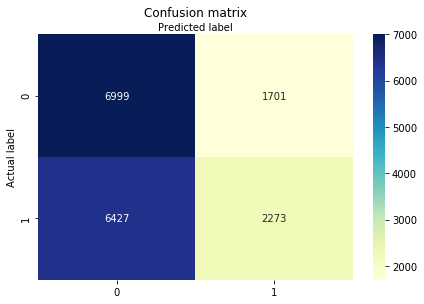

In [50]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [51]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F-Score:",metrics.f1_score(y_test, y_pred))

Accuracy: 0.5328735632183909
Precision: 0.5719677906391545
Recall: 0.26126436781609197
F-Score: 0.35868707590342436


## Generate Test

In [52]:
with open('test.json') as f:
    test_json_data = json.load(f)

In [53]:
try:
    corpus_test = loadPickle('corpus_test')
except:
    stop_words = set(stopwords.words('english'))
    stop_words.union(set(string.punctuation))
    corpus_test = createCorpus(json_data, stop_words)
    makePickle('corpus_test', corpus)

In [54]:
try:
    pos_dict_test = loadPickle('pos_dic_test')
except:
    pos_dict_test = makePOSDict(corpus_test)
    makePickle('pos_dic_test', pos_dict_test)
    
next(iter(pos_dict_test.keys())), next(iter(pos_dict_test.values()))

('Beyoncé', 'n')

In [55]:
try:
    corpus_lemmatize_test = loadPickle('corpus_lemmatize_test')
except:
    corpus_lemmatize_test = ourLemmatize(pos_dict_test, corpus_test)
    makePickle('corpus_lemmatize_test', corpus_lemmatize_test)

In [56]:
test_jac_similarity = getJaccard(test_json_data, corpus_test)
test_cos_similarity = getCosine(word_2vec_cached, test_json_data, corpus_test)
test_questionWords  = getQuestionWords(test_json_data, corpus_test, question_words)
test_verbCounts, test_nounCounts  = getVerbNounCounts(test_json_data, corpus_test, corpus_lemmatize_test, pos_dict_test)
test_similarWords = getSimilarWordCount(test_json_data, corpus_test)

try:
    test_nerCounts = loadPickle('test_nerCounts')
except:
    test_nerCounts = getNERCounts(test_json_data, corpus_test, test_questionWords, question_words, qwordTagMap)

NameError: name 'corpus' is not defined

In [51]:
features = [test_jac_similarity, test_cos_similarity, test_verbCounts, test_nounCounts, test_nerCounts, test_similarWords, test_questionWords]
X_out,keys = makeFeatures(features)
X_out = oneHotEncode(6, X_out)
y_pred_test = logisticRegr.predict(X_out)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [53]:
saveToFile(y_pred_test, keys, "out_test")